# Bootstrap the RUV metric and display on a value diagram 

In [1]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import bz2

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *

In [3]:
plt.rcParams['figure.figsize'] = (8, 7)

plt.rcParams['font.family'] = "calibri"
plt.rcParams['font.size'] = "12.5"

colors = {
    'black': '#000000',
    'light_orange': '#E69F00',
    'light_blue': '#56B4E9',
    'green': '#009E73',
    'yellow': '#F0E442',
    'dark_blue': '#0072B2',
    'dark_orange': '#D55E00',
    'pink': '#CC79A7'
} 

# Example forecast dataset
### 7th day ahead forecast for Murray at Biggara (401012) generated using the MuTHRE method

In [4]:
dataset_filepath = 'example_data.pickle.bz2'
parallel_nodes = 28
alpha_step = 0.01
bootstrap_samples = 1000
confidence_level = 0.95
verbose = True

In [5]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'].T, data['fcst'].T
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(276,) (276, 100) (276, 496)


# Define decision context

In [8]:
decision_definition = {
    'alphas': np.arange(alpha_step, 1, alpha_step),
    'damage_function': [binary, {'max_loss': 1, 'min_loss': 0, 'threshold': 0.75}],
    'utility_function': [cara, {'A': 0}],
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_thresholds': np.nanquantile(obs, [0, 0.75])
}

# 'decision_method' defaults to 'optimise_over_forecast_distribution'

ref = None  # use event frequency as the reference forecast

# Calculate RUV and run a bootstrap to find confidence intervals of the metric

In [9]:
results = relative_utility_value_bootstrap(obs, fcst_ens, ref, decision_definition, parallel_nodes, verbose, bootstrap_samples, confidence_level)

Bootstrap will take approximatly 504 minutes
Bootstrap sample: 5 / 1000
Bootstrap sample: 10 / 1000
Bootstrap sample: 15 / 1000
Bootstrap sample: 20 / 1000
Bootstrap sample: 25 / 1000
Bootstrap sample: 30 / 1000
Bootstrap sample: 35 / 1000
Bootstrap sample: 40 / 1000
Bootstrap sample: 45 / 1000
Bootstrap sample: 50 / 1000
Bootstrap sample: 55 / 1000
Bootstrap sample: 60 / 1000
Bootstrap sample: 65 / 1000
Bootstrap sample: 70 / 1000
Bootstrap sample: 75 / 1000
Bootstrap sample: 80 / 1000
Bootstrap sample: 85 / 1000
Bootstrap sample: 90 / 1000
Bootstrap sample: 95 / 1000
Bootstrap sample: 100 / 1000
Bootstrap sample: 105 / 1000
Bootstrap sample: 110 / 1000
Bootstrap sample: 115 / 1000
Bootstrap sample: 120 / 1000
Bootstrap sample: 125 / 1000
Bootstrap sample: 130 / 1000
Bootstrap sample: 135 / 1000
Bootstrap sample: 140 / 1000
Bootstrap sample: 145 / 1000
Bootstrap sample: 150 / 1000
Bootstrap sample: 155 / 1000
Bootstrap sample: 160 / 1000
Bootstrap sample: 165 / 1000
Bootstrap sample: 

In [15]:
results_bootstrap = results['bootstrap']
results_optim = results['complete']

ci_low = results_bootstrap.confidence_interval.low
ci_high = results_bootstrap.confidence_interval.high

# Plot results on a value diagram

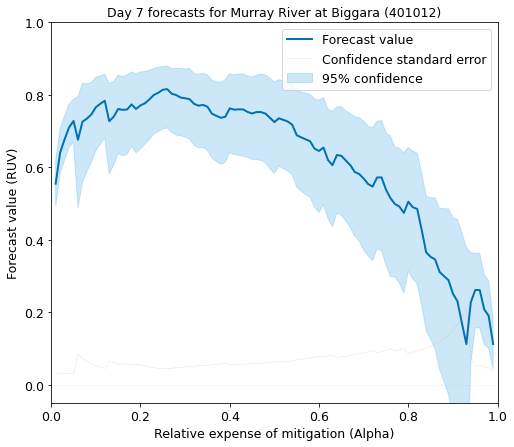

In [16]:
plt.plot(decision_definition['alphas'], results_optim['ruv'], color=colors['dark_blue'], linewidth=2, alpha=1.0, label='Forecast value')
plt.fill_between(decision_definition['alphas'], ci_low, ci_high, color=colors['light_blue'], alpha=0.3, label='95% confidence')
plt.axhline(0, color='grey', linewidth=0.5, alpha=0.3, linestyle='dotted')
plt.plot(decision_definition['alphas'], results_bootstrap.standard_error, color=colors['dark_orange'], linewidth=0.5, alpha=0.5, linestyle='dotted', label='Confidence standard error')
plt.ylim(0, 1)
plt.xlim((0, 1))
plt.ylim(-0.05, 1)
plt.xlabel('Relative expense of mitigation (Alpha)')
plt.ylabel('Forecast value (RUV)')
plt.title('Day 7 forecasts for Murray River at Biggara (401012)', fontsize='medium')
plt.legend()

plt.savefig('ruv_bootstrap.png')

(array([  8.,  20.,  67., 121., 217., 250., 197.,  92.,  24.,   4.]),
 array([0.52871731, 0.56751145, 0.60630559, 0.64509973, 0.68389387,
        0.72268802, 0.76148216, 0.8002763 , 0.83907044, 0.87786458,
        0.91665872]),
 <BarContainer object of 10 artists>)

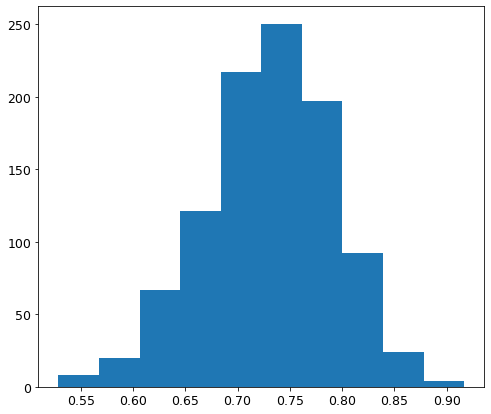

In [26]:
plt.hist(results_bootstrap.bootstrap_distribution[50])

In [34]:
with open(r"ruv_bootstrap_distribution.pickle", "wb") as output_file:
    pickle.dump(results_bootstrap.bootstrap_distribution, output_file)
                
with open(r"ruv_confidence_interval.pickle", "wb") as output_file:
    pickle.dump(results_bootstrap.confidence_interval, output_file)
    
with open(r"ruv_standard_error.pickle", "wb") as output_file:
    pickle.dump(results_bootstrap.standard_error, output_file)